In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!ls /content/drive/MyDrive/Colab\ Notebooks/Daily_Demand_Forecasting_Orders.csv ##/content/drive/MyDrive/Colab Notebooks/Australian_Vehicle_Prices.csv
!pwd

Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/Daily_Demand_Forecasting_Orders.csv'
/content


Load the data

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Daily_Demand_Forecasting_Orders.csv", delimiter=';')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 1   Day of the week (Monday to Friday)                                  60 non-null     int64  
 2   Non-urgent order                                                    60 non-null     float64
 3   Urgent order                                                        60 non-null     float64
 4   Order type A                                                        60 non-null     float64
 5   Order type B                                                        60 non-null     float64
 6   Order type C                                                        60 non-null     float64
 7   Fiscal sector order

EDA

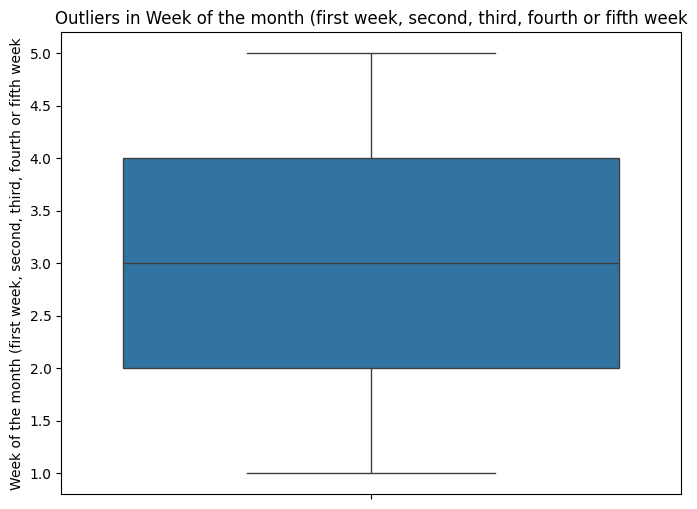

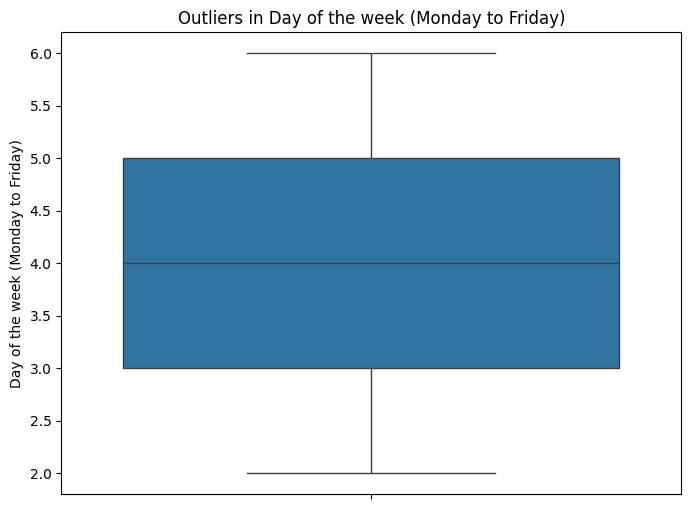

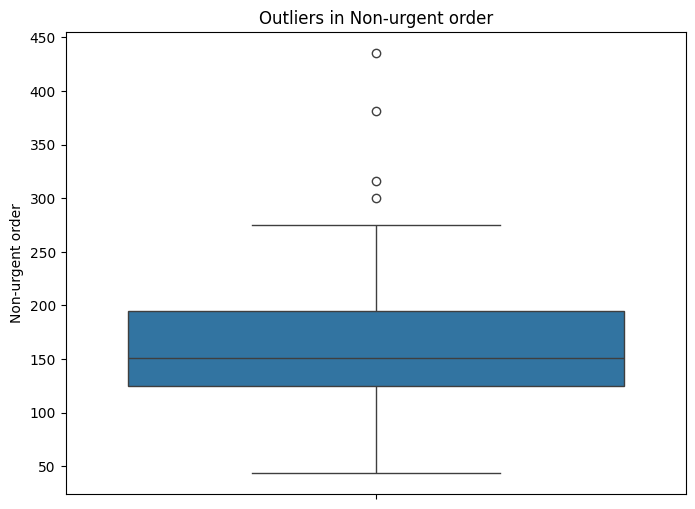

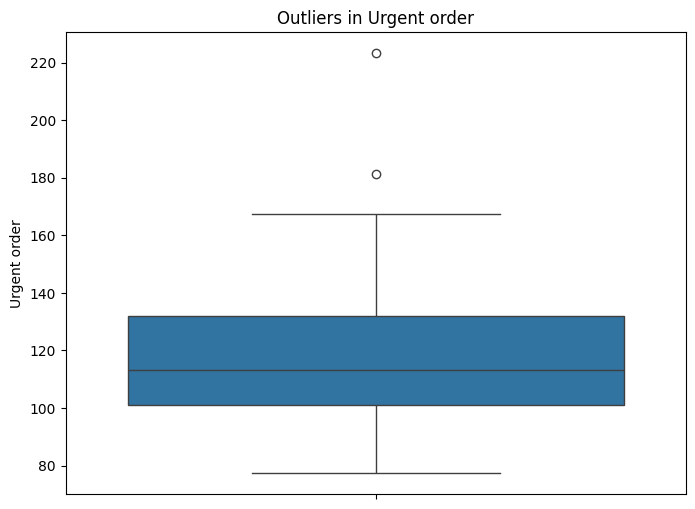

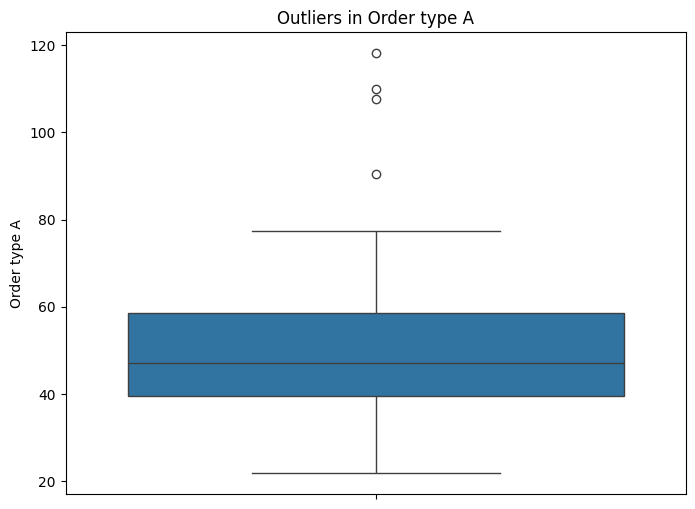

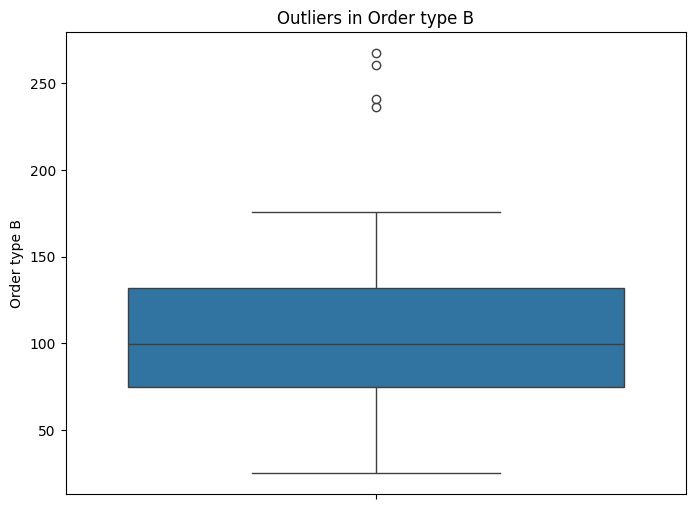

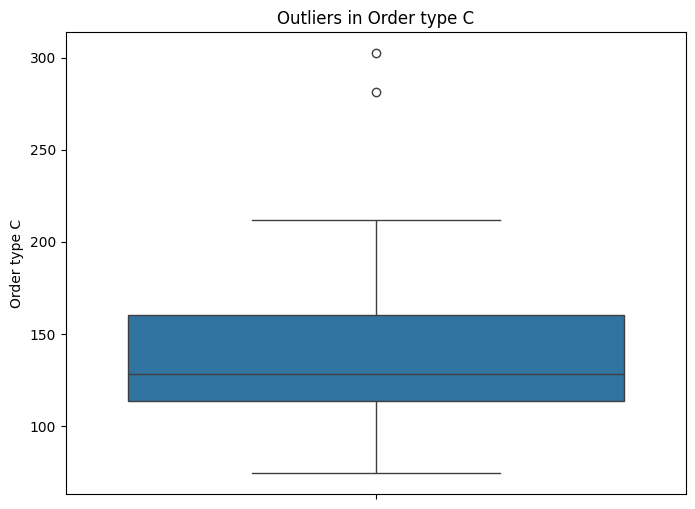

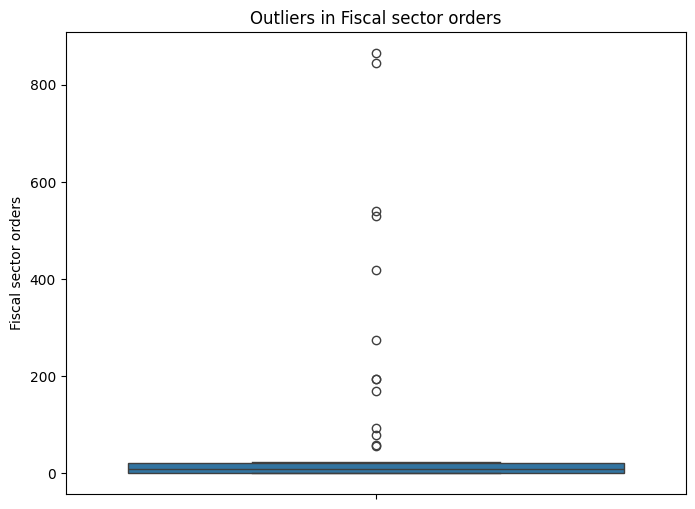

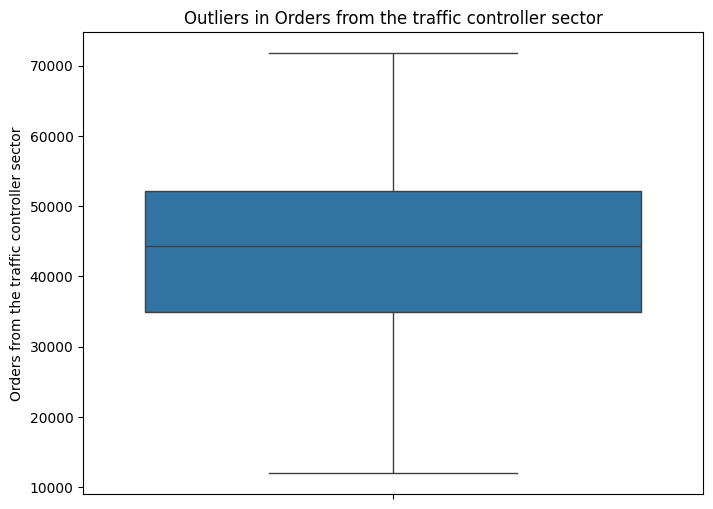

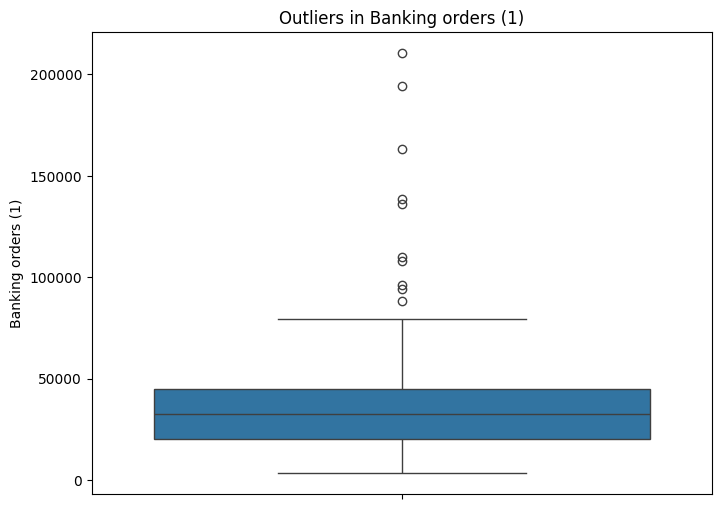

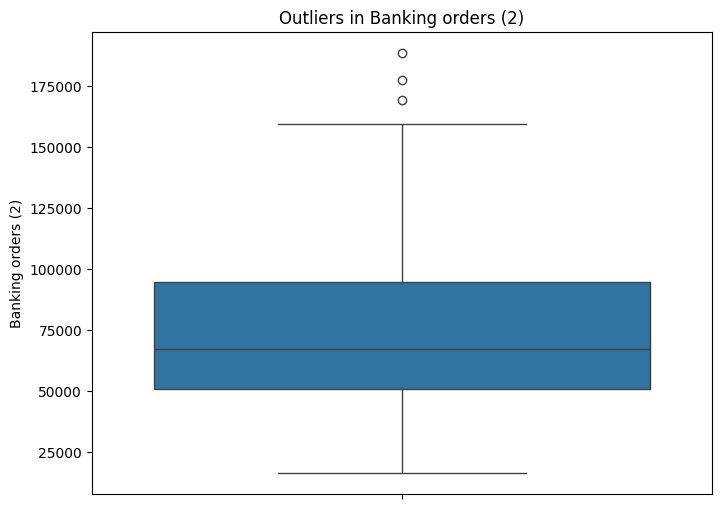

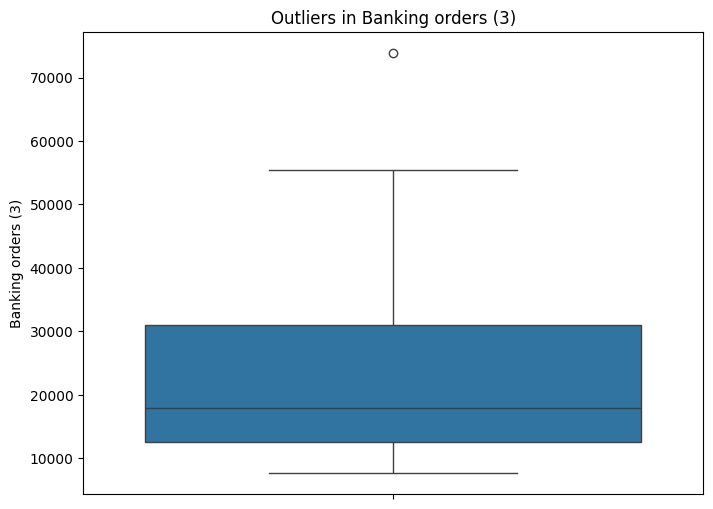

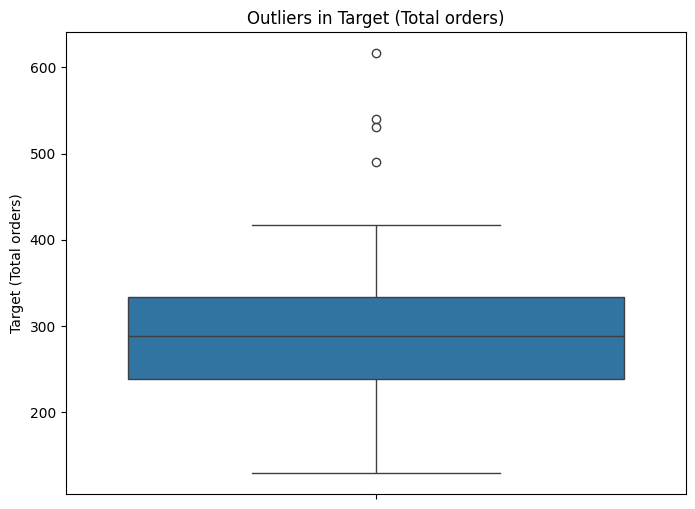

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = df.columns[ : ]

for i in columns:
    if pd.api.types.is_numeric_dtype(df[i]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=df[i])
        plt.title(f'Outliers in {i}')
        plt.show()


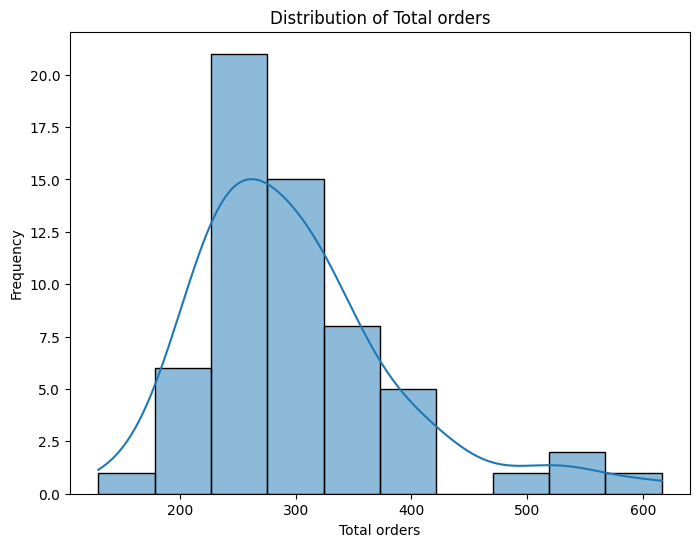

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Target (Total orders)'].dropna(), kde=True)
plt.title("Distribution of Total orders")
plt.xlabel("Total orders")
plt.ylabel("Frequency")
plt.show()

Modelling

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVR

X = df.drop(columns=['Target (Total orders)'])
y = df['Target (Total orders)']
results = {
    'Regression Tree': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Ridge Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Lasso Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Principal Component Regression (PCR)': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Regression Splines': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Support Vector Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []}
}
num_features = X.shape[1]

for _ in range(20):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)


    models = {
        'Regression Tree': DecisionTreeRegressor(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Principal Component Regression (PCR)': make_pipeline(StandardScaler(), PCA(n_components=num_features), LinearRegression()),
        'Regression Splines': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'Support Vector Regression': SVR()
    }

    for model_name, model in models.items():


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rss = np.sum((y_test - y_pred) ** 2)
        rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))
        r2 = r2_score(y_test, y_pred)


        results[model_name]['Test MSE'].append(mse)
        results[model_name]['Test RMSE'].append(rmse)
        results[model_name]['Test RSE'].append(rse)
        results[model_name]['Test RSS'].append(rss)
        results[model_name]['Test R^2'].append(r2)

average_results = {model: {metric: np.mean(scores) for metric, scores in metrics.items()} for model, metrics in results.items()}
results_df = pd.DataFrame(average_results)
results_df


,Regression Tree,Ridge Regression,Lasso Regression,Principal Component Regression (PCR),Regression Splines,Support Vector Regression
Test MSE,2141.487323,0.000497,0.084653,1.720152e-26,5.068334e+05,7638.679630
Test RMSE,44.396108,0.014114,0.235326,1.154701e-13,5.397532e+02,85.665809
Test RSE,84.235693,0.026779,0.446500,2.190890e-13,1.024110e+03,162.539445
Test RSS,38546.771815,0.008953,1.523750,3.096273e-25,9.123001e+06,137496.233331
Test R^2,0.694739,1.000000,0.999990,1.000000e+00,-7.027011e+01,-0.022186


Hyperparameter tuning and cross validation

Running GridSearchCV for Ridge Regression...
Ridge Regression - Best Parameters: {'ridge__alpha': 0.01}
Ridge Regression - Metrics: {'MSE': 0.16229366045722637, 'RMSE': 0.4028568734144006, 'RSE': 0.7643671746261838, 'RSS': 2.9212858882300745, 'R²': 0.999981789039049}



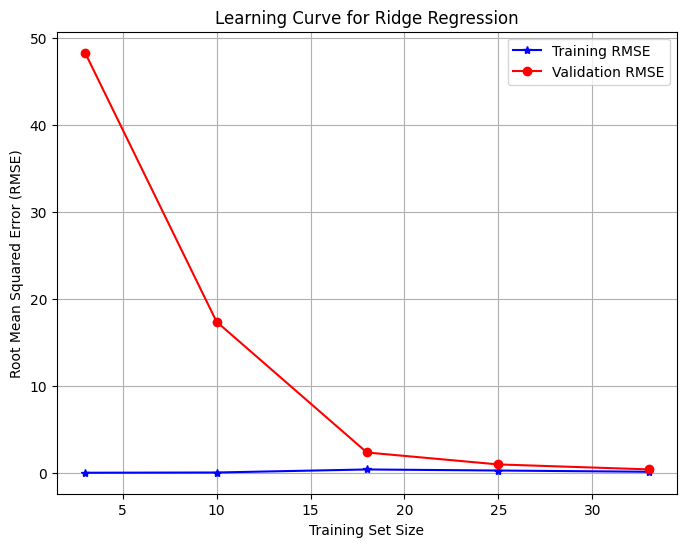

Running GridSearchCV for Lasso Regression...
Lasso Regression - Best Parameters: {'lasso__alpha': 0.01}
Lasso Regression - Metrics: {'MSE': 0.02183931185239907, 'RMSE': 0.14778129737013096, 'RSE': 0.2803952971585591, 'RSS': 0.3931076133431833, 'R²': 0.9999975494122554}



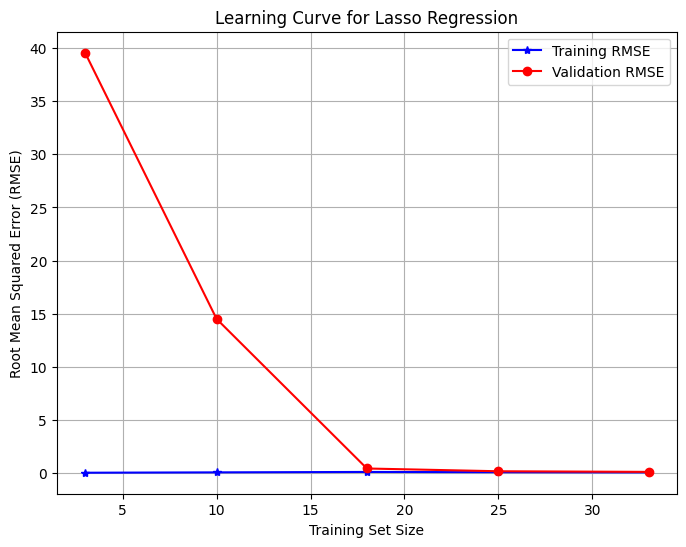

Running GridSearchCV for Principal Component Regression (PCR)...
Principal Component Regression (PCR) - Best Parameters: {'pca__n_components': 6}
Principal Component Regression (PCR) - Metrics: {'MSE': 753.2352868095205, 'RMSE': 27.4451322971765, 'RSE': 52.073477246236145, 'RSS': 13558.235162571369, 'R²': 0.9154795180761219}



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/sklea

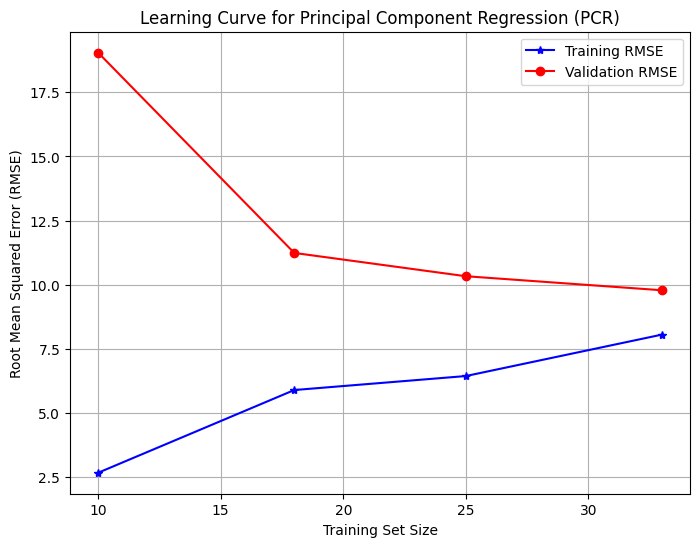

Running GridSearchCV for Regression Splines...
Regression Splines - Best Parameters: {'polynomialfeatures__degree': 2}
Regression Splines - Metrics: {'MSE': 1350.0038280517406, 'RMSE': 36.742398234896704, 'RSE': 69.71379907153437, 'RSS': 24300.06890493133, 'R²': 0.8485161593672551}



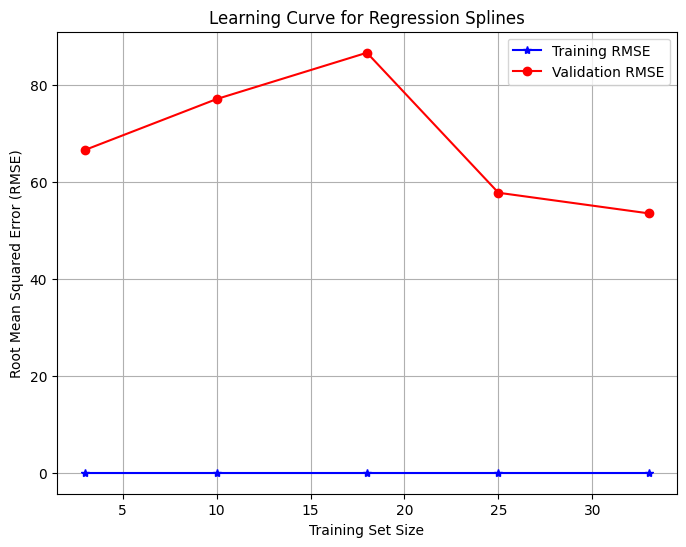

Running GridSearchCV for Regression Tree...
Regression Tree - Best Parameters: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}
Regression Tree - Metrics: {'MSE': 5305.952368166549, 'RMSE': 72.84196845340294, 'RSE': 138.20791773773158, 'RSS': 95507.14262699788, 'R²': 0.40461943422469193}



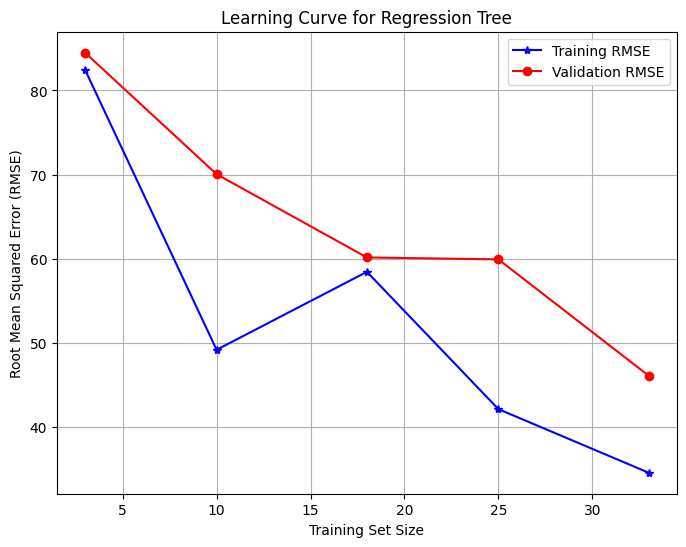

Running GridSearchCV for Support Vector Regression (SVR)...
Support Vector Regression (SVR) - Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.1}
Support Vector Regression (SVR) - Metrics: {'MSE': 7519.184728857907, 'RMSE': 86.7132327206056, 'RSE': 164.52679120401172, 'RSS': 135345.32511944234, 'R²': 0.1562727767977664}



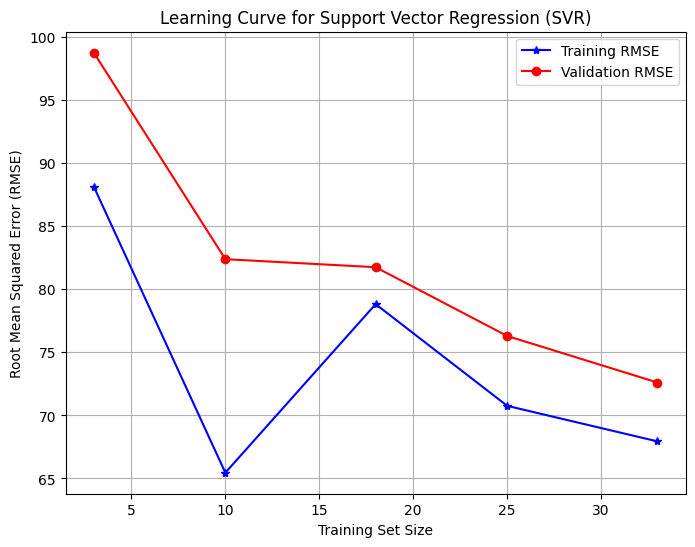


Model Performance Metrics:
                                              MSE       RMSE         RSE  \
Ridge Regression                         0.162294   0.402857    0.764367   
Lasso Regression                         0.021839   0.147781    0.280395   
Principal Component Regression (PCR)   753.235287  27.445132   52.073477   
Regression Splines                    1350.003828  36.742398   69.713799   
Regression Tree                       5305.952368  72.841968  138.207918   
Support Vector Regression (SVR)       7519.184729  86.713233  164.526791   

                                                RSS        R²  
Ridge Regression                           2.921286  0.999982  
Lasso Regression                           0.393108  0.999998  
Principal Component Regression (PCR)   13558.235163  0.915480  
Regression Splines                     24300.068905  0.848516  
Regression Tree                        95507.142627  0.404619  
Support Vector Regression (SVR)       135345.325119  0.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

X = df.drop(columns=['Target (Total orders)'])
y = df['Target (Total orders)']

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scaling the features
scalr = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#compute the range for PCA n_components dynamically
max_components = min(X_train_scaled.shape[1], X_train_scaled.shape[0] // 5)

#parameter grids for all models
param_grids = {
    'Ridge Regression': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'lasso__alpha': [0.01, 0.1, 1, 10, 100]},
    'Principal Component Regression (PCR)': {'pca__n_components': list(range(1, max_components + 1))},
    'Regression Splines': {'polynomialfeatures__degree': [2, 3, 4]},
    'Regression Tree': {
        'decisiontreeregressor__max_depth': [3, 4, 5],
        'decisiontreeregressor__min_samples_split': [10, 15, 20],
        'decisiontreeregressor__min_samples_leaf': [4, 8, 10]
    },
    'Support Vector Regression (SVR)': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.1, 0.5, 1]}
}

#calculate performance metrics
def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rss = np.sum((y_true - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_true) - n_features - 1))
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'RSE': rse, 'RSS': rss, 'R²': r2}

#plot learning curves
def plot_learning_curve(model, X, y, model_name, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='*', color='blue')
    plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='o', color='red')
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.legend()
    plt.grid()
    plt.show()

#run GridSearchCV
results = {}
best_parameters = {}

for model_name, grid_params in param_grids.items():
    print(f"Running GridSearchCV for {model_name}...")
    if model_name == 'Principal Component Regression (PCR)':
        model = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    elif model_name == 'Regression Splines':
        model = make_pipeline(PolynomialFeatures(), LinearRegression())
    elif model_name == 'Ridge Regression':
        model = make_pipeline(StandardScaler(), Ridge(max_iter=5000))
    elif model_name == 'Lasso Regression':
        model = make_pipeline(StandardScaler(), Lasso(max_iter=5000))
    elif model_name == 'Regression Tree':
        model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
    elif model_name == 'Support Vector Regression (SVR)':
        model = make_pipeline(StandardScaler(), SVR())
    grid_search = GridSearchCV(model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    #best parameters
    best_parameters[model_name] = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    metrics = calculate_metrics(y_test, y_pred, X_test_scaled.shape[1])
    results[model_name] = metrics

    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Metrics: {metrics}\n")

    #plot learning curve
    plot_learning_curve(best_model, X_train_scaled, y_train, model_name)

#results
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)

#best parameters for each model
print("\nBest Parameters for Each Model:")
for model_name, params in best_parameters.items():
    print(f"{model_name}: {params}")
